## Visualizing relative amino acid changes as radar plots

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

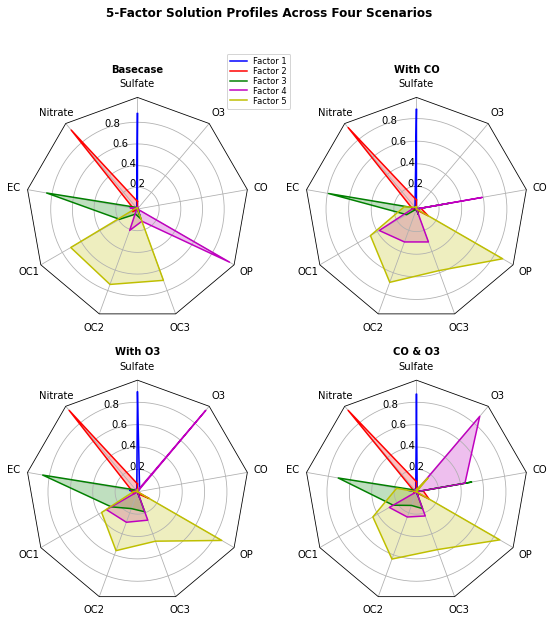

In [2]:
# EXAMPLE CODE FROM https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

### Read in relative AA compositions

In [3]:
MS = pd.read_csv("/home/millieginty/Documents/git-repos/amazon/analyses/T7-incubations/AA-comp/MS-RelNAAF-AAs.csv", index_col = 'sample')

del MS['Unnamed: 0']

aa_names = ['Ala', 'Cys', 'Asp', 'Glu', 'Phe', 'Gly', 'His', 'Lys', 'Leu/Ile', 'Met', 'Asn', \
         'Pro', 'Gln', 'Arg', 'Ser', 'Thr', 'Val', 'Trp', 'Tyr']

MS.columns = aa_names

MS_o = MS[['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln']]

MS_o.head()

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3,0.086777,0.133445,0.149427,0.111991,0.163000,0.098011,0.100943,0.020035,0.019832,0.015600,0.014016,0.005179,0.008648,0.007915,0.013728,0.039457,0.001516,0.005224,0.005257
T0 0.7,0.091952,0.197706,0.158885,0.115810,0.122141,0.106268,0.111514,0.011457,0.004621,0.007304,0.011889,0.004355,0.007334,0.008656,0.005987,0.020562,0.001933,0.003748,0.007880
T24 0.3,0.083810,0.206529,0.133145,0.122344,0.125528,0.117162,0.108130,0.013011,0.003474,0.001321,0.004415,0.010255,0.018259,0.014094,0.008669,0.020056,0.001763,0.006495,0.001539
T24 0.7,0.090156,0.203536,0.146433,0.117644,0.144593,0.118351,0.113862,0.006778,0.003247,0.003609,0.003150,0.003883,0.005948,0.004732,0.004695,0.023798,0.000866,0.003184,0.001533


In [4]:
MN = pd.read_csv("/home/millieginty/Documents/git-repos/amazon/analyses/T7-incubations/AA-comp/MN-RelNAAF-AAs.csv", index_col = 'sample')

del MN['Unnamed: 0']

aa_names = ['Ala', 'Cys', 'Asp', 'Glu', 'Phe', 'Gly', 'His', 'Lys', 'Leu/Ile', 'Met', 'Asn', \
         'Pro', 'Gln', 'Arg', 'Ser', 'Thr', 'Val', 'Trp', 'Tyr']

MN.columns = aa_names

MN_o = MN[['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln']]

MN_o.head()

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3-0.7 um,0.100699,0.177755,0.166523,0.113370,0.147315,0.108715,0.112323,0.012378,0.001024,0.004374,0.005938,0.001531,0.002691,0.005038,0.002760,0.027485,0.000740,0.002052,0.007288
T0 >0.7 um,0.072288,0.221635,0.147892,0.116369,0.113888,0.118063,0.110695,0.015047,0.006634,0.004624,0.009466,0.006683,0.011278,0.011096,0.009530,0.016819,0.000943,0.003925,0.003125
T24 0.3-0.7 um,0.088894,0.173103,0.132866,0.100536,0.120089,0.109274,0.090467,0.033097,0.023346,0.004210,0.010155,0.010044,0.013400,0.021354,0.012743,0.024937,0.010730,0.010687,0.010069
T24 >0.7 um,0.084934,0.221249,0.149951,0.112187,0.140319,0.114786,0.113782,0.008483,0.002809,0.003974,0.003851,0.002933,0.001873,0.005437,0.002675,0.023894,0.001022,0.000908,0.004931


In [5]:
CV = pd.read_csv("/home/millieginty/Documents/git-repos/amazon/analyses/T7-incubations/AA-comp/CV-RelNAAF-AAs.csv", index_col = 'sample')

del CV['Unnamed: 0']

aa_names = ['Ala', 'Cys', 'Asp', 'Glu', 'Phe', 'Gly', 'His', 'Lys', 'Leu/Ile', 'Met', 'Asn', \
         'Pro', 'Gln', 'Arg', 'Ser', 'Thr', 'Val', 'Trp', 'Tyr']

CV.columns = aa_names

CV_o = CV[['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln']]

CV_o.head()

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3-0.7 um,0.084137,0.190533,0.139610,0.112595,0.133220,0.110561,0.109000,0.013445,0.012872,0.005704,0.007886,0.006989,0.012741,0.014644,0.012495,0.021417,0.003772,0.003651,0.004727
T0 >0.7 um,0.081667,0.212413,0.143524,0.114573,0.134599,0.116623,0.113320,0.009914,0.002006,0.005797,0.008546,0.005753,0.007359,0.004776,0.003878,0.026520,0.001468,0.003206,0.004057
T24 0.3-0.7 um,0.089631,0.218419,0.140452,0.115884,0.135145,0.118381,0.113825,0.008105,0.003694,0.001913,0.003321,0.003883,0.005444,0.006542,0.003586,0.019980,0.001873,0.003624,0.006299
T24 >0.7 um,0.092855,0.221745,0.143886,0.119432,0.137942,0.123969,0.117669,0.004845,0.002007,0.002443,0.002288,0.001910,0.003017,0.003449,0.002755,0.016152,0.000670,0.001702,0.001264


In [6]:
BY = pd.read_csv("/home/millieginty/Documents/git-repos/amazon/analyses/T7-incubations/AA-comp/BY-RelNAAF-AAs.csv", index_col = 'sample')

del BY['Unnamed: 0']

aa_names = ['Ala', 'Cys', 'Asp', 'Glu', 'Phe', 'Gly', 'His', 'Lys', 'Leu/Ile', 'Met', 'Asn', \
         'Pro', 'Gln', 'Arg', 'Ser', 'Thr', 'Val', 'Trp', 'Tyr']

BY.columns = aa_names

BY_o = BY[['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln']]

BY_o.head()

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3-0.7 um,0.094113,0.194227,0.150268,0.100039,0.126293,0.100670,0.104286,0.016723,0.004105,0.016742,0.016772,0.005416,0.010163,0.007544,0.007069,0.027175,0.003772,0.004819,0.009806
T0 >0.7 um,0.084200,0.185256,0.153479,0.114650,0.166538,0.117521,0.114391,0.004656,0.001302,0.001619,0.002934,0.002740,0.004242,0.002576,0.002420,0.035172,0.001160,0.002493,0.002652
T24 0.3-0.7 um,0.076693,0.217488,0.133507,0.117847,0.123229,0.116366,0.110319,0.012688,0.006128,0.001525,0.004894,0.008766,0.016629,0.008423,0.009433,0.020485,0.003202,0.009936,0.002441
T24 >0.7 um,0.084908,0.205933,0.144311,0.119292,0.134041,0.126828,0.115336,0.008742,0.003825,0.003242,0.002154,0.003459,0.009079,0.004375,0.006761,0.020856,0.000816,0.004203,0.001840


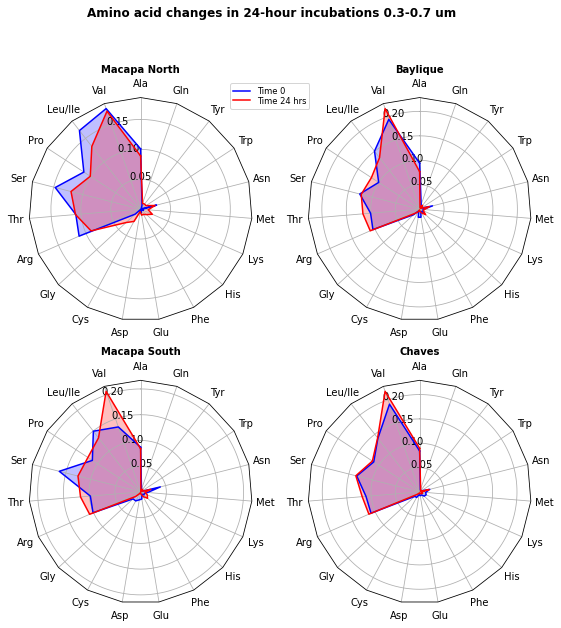

In [7]:
# SMALL SIZE FRACTION


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data are relative amino acid compositions
    # For each of the four stations
    # At T=0 hrs and T = 24 hrs
    
    data = [
        ['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln'],
        ('Macapa North', [
            MN_o.iloc[0].values,
            MN_o.iloc[2].values]),
        ('Baylique', [
            BY_o.iloc[0].values,
            BY_o.iloc[2].values]),
        ('Macapa South', [
            MS_o.iloc[0].values,
            MS_o.iloc[2].values]),
        ('Chaves', [
            CV_o.iloc[0].values,
            CV_o.iloc[2].values]),
    ]
    return data


if __name__ == '__main__':
    N = 19
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r']
    # Plot the two cases from the data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.05, 0.1, 0.15, 0.2])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Time 0', 'Time 24 hrs')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Amino acid changes in 24-hour incubations 0.3-0.7 um',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

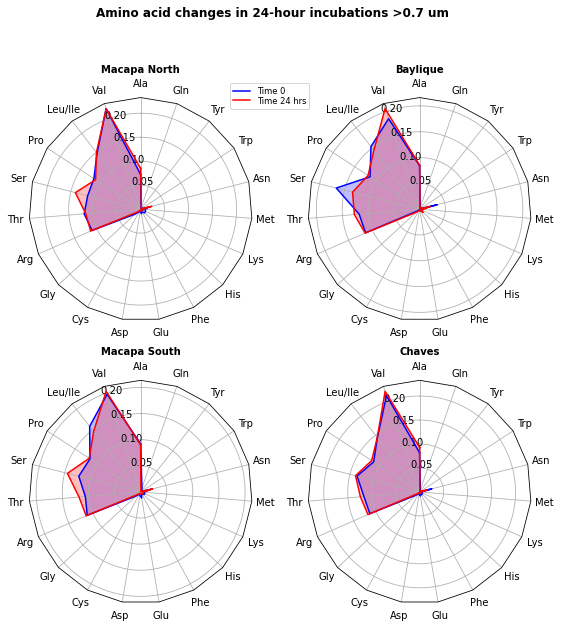

In [8]:
# LARGE SIZE FRACTION


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data are relative amino acid compositions
    # For each of the four stations
    # At T=0 hrs and T = 24 hrs
    
    data = [
        ['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln'],
        ('Macapa North', [
            MN_o.iloc[1].values,
            MN_o.iloc[3].values]),
        ('Baylique', [
            BY_o.iloc[1].values,
            BY_o.iloc[3].values]),
        ('Macapa South', [
            MS_o.iloc[1].values,
            MS_o.iloc[3].values]),
        ('Chaves', [
            CV_o.iloc[1].values,
            CV_o.iloc[3].values]),
    ]
    return data


if __name__ == '__main__':
    N = 19
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r']
    # Plot the two cases from the data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.05, 0.1, 0.15, 0.2])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Time 0', 'Time 24 hrs')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Amino acid changes in 24-hour incubations >0.7 um',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

## Amino acid log2 change plots

In [9]:
MS_T = MS_o.T

MS_T.head()

sample,T0 0.3,T0 0.7,T24 0.3,T24 0.7
Ala,0.086777,0.091952,0.083810,0.090156
Val,0.133445,0.197706,0.206529,0.203536
Leu/Ile,0.149427,0.158885,0.133145,0.146433
Pro,0.111991,0.115810,0.122344,0.117644
Ser,0.163000,0.122141,0.125528,0.144593


In [10]:
MS_T['small delta'] = MS_T['T24 0.3'] - MS_T['T0 0.3']
MS_T['large delta'] = MS_T['T24 0.7'] - MS_T['T0 0.7']

MS_T['small log2'] = np.log2(MS_T['T24 0.3']) - np.log2(MS_T['T0 0.3'])
MS_T['large log2'] = np.log2(MS_T['T24 0.7']) - np.log2(MS_T['T0 0.7'])

MS_log = MS_T.T

MS_log.head(8)

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3,0.086777,0.133445,0.149427,0.111991,0.163000,0.098011,0.100943,0.020035,0.019832,0.015600,0.014016,0.005179,0.008648,0.007915,0.013728,0.039457,0.001516,0.005224,0.005257
T0 0.7,0.091952,0.197706,0.158885,0.115810,0.122141,0.106268,0.111514,0.011457,0.004621,0.007304,0.011889,0.004355,0.007334,0.008656,0.005987,0.020562,0.001933,0.003748,0.007880
T24 0.3,0.083810,0.206529,0.133145,0.122344,0.125528,0.117162,0.108130,0.013011,0.003474,0.001321,0.004415,0.010255,0.018259,0.014094,0.008669,0.020056,0.001763,0.006495,0.001539
T24 0.7,0.090156,0.203536,0.146433,0.117644,0.144593,0.118351,0.113862,0.006778,0.003247,0.003609,0.003150,0.003883,0.005948,0.004732,0.004695,0.023798,0.000866,0.003184,0.001533
small delta,-0.002967,0.073083,-0.016282,0.010352,-0.037471,0.019151,0.007187,-0.007024,-0.016358,-0.014279,-0.009601,0.005076,0.009611,0.006179,-0.005059,-0.019401,0.000247,0.001271,-0.003718
large delta,-0.001796,0.005830,-0.012452,0.001834,0.022453,0.012083,0.002348,-0.004680,-0.001374,-0.003695,-0.008738,-0.000472,-0.001386,-0.003924,-0.001292,0.003237,-0.001067,-0.000564,-0.006347
small log2,-0.050193,0.630094,-0.166438,0.127550,-0.376854,0.257488,0.099232,-0.622775,-2.513073,-3.561590,-1.666488,0.985597,1.078243,0.832395,-0.663223,-0.976224,0.217436,0.314232,-1.772144
large log2,-0.028456,0.041926,-0.117741,0.022666,0.243460,0.155370,0.030067,-0.757421,-0.509048,-1.017198,-1.915958,-0.165415,-0.302278,-0.871102,-0.350652,0.210912,-1.157872,-0.235219,-2.361545


In [11]:
MN_T = MN_o.T

MN_T['small delta'] = MN_T['T24 0.3-0.7 um'] - MN_T['T0 0.3-0.7 um']
MN_T['large delta'] = MN_T['T24 >0.7 um'] - MN_T['T0 >0.7 um']

MN_T['small log2'] = np.log2(MN_T['T24 0.3-0.7 um']) - np.log2(MN_T['T0 0.3-0.7 um'])
MN_T['large log2'] = np.log2(MN_T['T24 >0.7 um']) - np.log2(MN_T['T0 >0.7 um'])

MN_log = MN_T.T

MN_log.head(8)

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3-0.7 um,0.100699,0.177755,0.166523,0.113370,0.147315,0.108715,0.112323,0.012378,0.001024,0.004374,0.005938,0.001531,0.002691,0.005038,0.002760,0.027485,0.000740,0.002052,0.007288
T0 >0.7 um,0.072288,0.221635,0.147892,0.116369,0.113888,0.118063,0.110695,0.015047,0.006634,0.004624,0.009466,0.006683,0.011278,0.011096,0.009530,0.016819,0.000943,0.003925,0.003125
T24 0.3-0.7 um,0.088894,0.173103,0.132866,0.100536,0.120089,0.109274,0.090467,0.033097,0.023346,0.004210,0.010155,0.010044,0.013400,0.021354,0.012743,0.024937,0.010730,0.010687,0.010069
T24 >0.7 um,0.084934,0.221249,0.149951,0.112187,0.140319,0.114786,0.113782,0.008483,0.002809,0.003974,0.003851,0.002933,0.001873,0.005437,0.002675,0.023894,0.001022,0.000908,0.004931
small delta,-0.011805,-0.004651,-0.033658,-0.012835,-0.027226,0.000558,-0.021857,0.020720,0.022322,-0.000164,0.004217,0.008513,0.010709,0.016315,0.009984,-0.002548,0.009990,0.008634,0.002781
large delta,0.012647,-0.000386,0.002059,-0.004182,0.026431,-0.003276,0.003087,-0.006564,-0.003825,-0.000650,-0.005615,-0.003750,-0.009405,-0.005658,-0.006854,0.007076,0.000080,-0.003017,0.001805
small log2,-0.179891,-0.038252,-0.325757,-0.173336,-0.294802,0.007391,-0.312202,1.418988,4.510315,-0.055054,0.774209,2.714203,2.316243,2.083414,2.207073,-0.140345,3.857679,2.380394,0.466315
large log2,0.232599,-0.002512,0.019947,-0.052799,0.301091,-0.040600,0.039684,-0.826797,-1.239758,-0.218576,-1.297608,-1.188102,-2.590374,-1.029005,-1.832698,0.506601,0.116875,-2.112181,0.657682


In [12]:
BY_T = BY_o.T

BY_T['small delta'] = BY_T['T24 0.3-0.7 um'] - BY_T['T0 0.3-0.7 um']
BY_T['large delta'] = BY_T['T24 >0.7 um'] - BY_T['T0 >0.7 um']

BY_T['small log2'] = np.log2(BY_T['T24 0.3-0.7 um']) - np.log2(BY_T['T0 0.3-0.7 um'])
BY_T['large log2'] = np.log2(BY_T['T24 >0.7 um']) - np.log2(BY_T['T0 >0.7 um'])

BY_log = BY_T.T

BY_log.head(8)

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3-0.7 um,0.094113,0.194227,0.150268,0.100039,0.126293,0.100670,0.104286,0.016723,0.004105,0.016742,0.016772,0.005416,0.010163,0.007544,0.007069,0.027175,0.003772,0.004819,0.009806
T0 >0.7 um,0.084200,0.185256,0.153479,0.114650,0.166538,0.117521,0.114391,0.004656,0.001302,0.001619,0.002934,0.002740,0.004242,0.002576,0.002420,0.035172,0.001160,0.002493,0.002652
T24 0.3-0.7 um,0.076693,0.217488,0.133507,0.117847,0.123229,0.116366,0.110319,0.012688,0.006128,0.001525,0.004894,0.008766,0.016629,0.008423,0.009433,0.020485,0.003202,0.009936,0.002441
T24 >0.7 um,0.084908,0.205933,0.144311,0.119292,0.134041,0.126828,0.115336,0.008742,0.003825,0.003242,0.002154,0.003459,0.009079,0.004375,0.006761,0.020856,0.000816,0.004203,0.001840
small delta,-0.017420,0.023260,-0.016760,0.017808,-0.003064,0.015696,0.006034,-0.004035,0.002023,-0.015218,-0.011877,0.003350,0.006466,0.000879,0.002365,-0.006689,-0.000570,0.005117,-0.007365
large delta,0.000708,0.020677,-0.009168,0.004642,-0.032497,0.009307,0.000945,0.004087,0.002523,0.001623,-0.000780,0.000719,0.004837,0.001800,0.004341,-0.014316,-0.000344,0.001711,-0.000812
small log2,-0.295300,0.163188,-0.170615,0.236352,-0.035431,0.209032,0.081144,-0.398333,0.578028,-3.456999,-1.776880,0.694746,0.710353,0.159046,0.416368,-0.407680,-0.236142,1.043953,-2.006112
large log2,0.012080,0.152653,-0.088861,0.057256,-0.313176,0.109952,0.011873,0.909008,1.554438,1.001583,-0.446047,0.336225,1.097807,0.764494,1.482127,-0.753948,-0.508023,0.753861,-0.527634


In [13]:
CV_T = CV_o.T

CV_T['small delta'] = CV_T['T24 0.3-0.7 um'] - CV_T['T0 0.3-0.7 um']
CV_T['large delta'] = CV_T['T24 >0.7 um'] - CV_T['T0 >0.7 um']

CV_T['small log2'] = np.log2(CV_T['T24 0.3-0.7 um']) - np.log2(CV_T['T0 0.3-0.7 um'])
CV_T['large log2'] = np.log2(CV_T['T24 >0.7 um']) - np.log2(CV_T['T0 >0.7 um'])

CV_log = CV_T.T

CV_log.head(8)

,Ala,Val,Leu/Ile,Pro,Ser,Thr,Arg,Gly,Cys,Asp,Glu,Phe,His,Lys,Met,Asn,Trp,Tyr,Gln
sample,,,,,,,,,,,,,,,,,,,
T0 0.3-0.7 um,0.084137,0.190533,0.139610,0.112595,0.133220,0.110561,0.109000,0.013445,1.287229e-02,0.005704,0.007886,0.006989,0.012741,0.014644,0.012495,0.021417,0.003772,0.003651,0.004727
T0 >0.7 um,0.081667,0.212413,0.143524,0.114573,0.134599,0.116623,0.113320,0.009914,2.006249e-03,0.005797,0.008546,0.005753,0.007359,0.004776,0.003878,0.026520,0.001468,0.003206,0.004057
T24 0.3-0.7 um,0.089631,0.218419,0.140452,0.115884,0.135145,0.118381,0.113825,0.008105,3.693968e-03,0.001913,0.003321,0.003883,0.005444,0.006542,0.003586,0.019980,0.001873,0.003624,0.006299
T24 >0.7 um,0.092855,0.221745,0.143886,0.119432,0.137942,0.123969,0.117669,0.004845,2.006999e-03,0.002443,0.002288,0.001910,0.003017,0.003449,0.002755,0.016152,0.000670,0.001702,0.001264
small delta,0.005493,0.027886,0.000842,0.003289,0.001925,0.007820,0.004826,-0.005340,-9.178326e-03,-0.003791,-0.004565,-0.003107,-0.007297,-0.008102,-0.008909,-0.001437,-0.001899,-0.000027,0.001571
large delta,0.011187,0.009332,0.000362,0.004858,0.003344,0.007346,0.004349,-0.005069,7.500401e-07,-0.003354,-0.006258,-0.003843,-0.004342,-0.001327,-0.001123,-0.010368,-0.000798,-0.001504,-0.002793
small log2,0.091243,0.197054,0.008674,0.041544,0.020697,0.098594,0.062496,-0.730198,-1.801026e+00,-1.576376,-1.247702,-0.848068,-1.226621,-1.162429,-1.800993,-0.100203,-1.009947,-0.010875,0.414064
large log2,0.185215,0.062030,0.003639,0.059911,0.035403,0.088124,0.054337,-1.033030,5.392537e-04,-1.246489,-1.901025,-1.590765,-1.286392,-0.469791,-0.493077,-0.715359,-1.132104,-0.913793,-1.682307


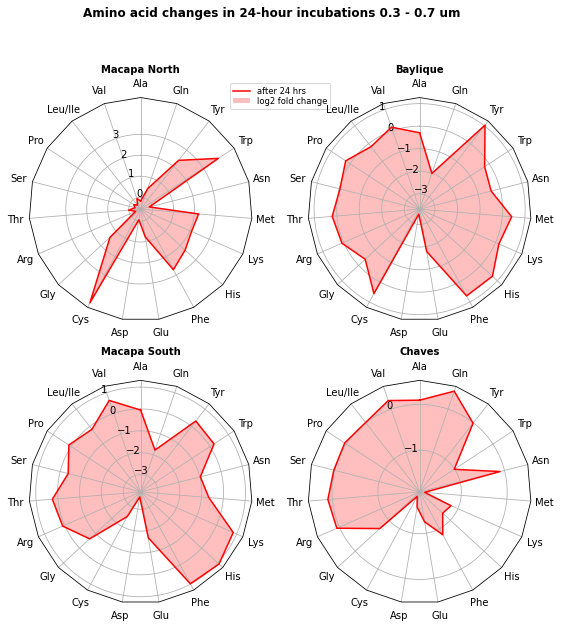

In [14]:
# SMALL SIZE FRACTION LOG2 fold change


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data are relative amino acid composition changes as log2 fold changes
    # For each of the four stations
    # After 24 hrs 
    
    data = [
        ['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln'],
        ('Macapa North', [
            MN_log.iloc[6].values]),
        ('Baylique', [
            BY_log.iloc[6].values]),
        ('Macapa South', [
            MS_log.iloc[6].values]),
        ('Chaves', [
            CV_log.iloc[6].values]),
    ]
    return data


if __name__ == '__main__':
    N = 19
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['r']
    # Plot the two cases from the data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([-3, -2, -1, 0, 1, 2, 3])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('after 24 hrs', 'log2 fold change')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Amino acid changes in 24-hour incubations 0.3 - 0.7 um',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

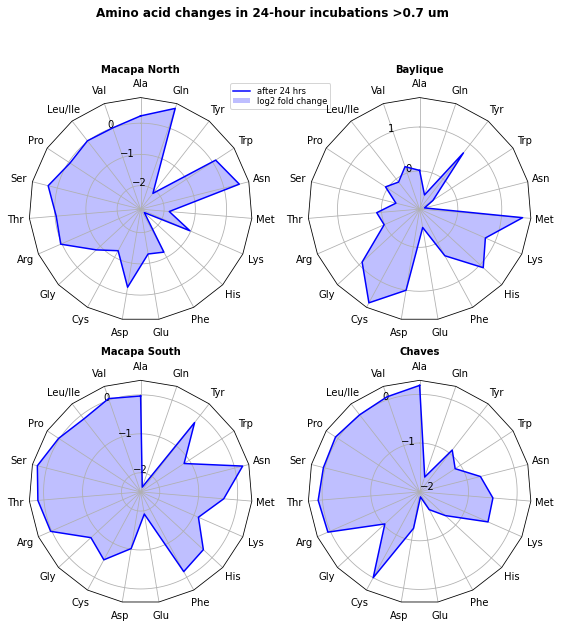

In [15]:
# LARGE SIZE FRACTION LOG2 fold change


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data are relative amino acid composition changes as log2 fold changes
    # For each of the four stations
    # After 24 hrs 
    
    data = [
        ['Ala', 'Val', 'Leu/Ile', 'Pro', 'Ser', 'Thr', 'Arg', 'Gly', 'Cys', 'Asp','Glu', 'Phe', 'His', \
           'Lys', 'Met', 'Asn', 'Trp', 'Tyr', 'Gln'],
        ('Macapa North', [
            MN_log.iloc[7].values]),
        ('Baylique', [
            BY_log.iloc[7].values]),
        ('Macapa South', [
            MS_log.iloc[7].values]),
        ('Chaves', [
            CV_log.iloc[7].values]),
    ]
    return data


if __name__ == '__main__':
    N = 19
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b']
    # Plot the two cases from the data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([-2, -1, 0, 1, 2, 3])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('after 24 hrs', 'log2 fold change')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Amino acid changes in 24-hour incubations >0.7 um',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()